In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

24/05/31 11:15:34 WARN Utils: Your hostname, Amols-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.201 instead (on interface en0)
24/05/31 11:15:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/31 11:15:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.functions import col, explode, split, avg


In [5]:
df_genome_scores = spark.read.csv("movielens/genome-scores.csv", header=True)
df_genome_tags = spark.read.csv("movielens/genome-tags.csv", header = True)
df_links = spark.read.csv("movielens/links.csv", header = True)
df_movies = spark.read.csv("movielens/movies.csv", header = True)
df_ratings = spark.read.csv("movielens/ratings.csv", header = True)
df_links = spark.read.csv("movielens/tags.csv", header = True)


In [51]:
df_links.show()

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|     3|    260|             classic|1439472355|
|     3|    260|              sci-fi|1439472256|
|     4|   1732|         dark comedy|1573943598|
|     4|   1732|      great dialogue|1573943604|
|     4|   7569|    so bad it's good|1573943455|
|     4|  44665|unreliable narrators|1573943619|
|     4| 115569|               tense|1573943077|
|     4| 115713|artificial intell...|1573942979|
|     4| 115713|       philosophical|1573943033|
|     4| 115713|               tense|1573943042|
|     4| 148426|    so bad it's good|1573942965|
|     4| 164909|              cliche|1573943721|
|     4| 164909|             musical|1573943714|
|     4| 168250|              horror|1573945163|
|     4| 168250|       unpredictable|1573945171|
|    19|   2160|Oscar (Best Suppo...|1446909853|
|    19|   7099|           adventure|1445286141|
|    19|   7099|    

In [6]:
df_merged = df_ratings.join(df_movies, on = "movieId")

### Merged Data

In [7]:

df_merged.show()

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|    296|     1|   5.0|1147880044| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    306|     1|   3.5|1147868817|Three Colors: Red...|               Drama|
|    307|     1|   5.0|1147868828|Three Colors: Blu...|               Drama|
|    665|     1|   5.0|1147878820|  Underground (1995)|    Comedy|Drama|War|
|    899|     1|   3.5|1147868510|Singin' in the Ra...|Comedy|Musical|Ro...|
|   1088|     1|   4.0|1147868495|Dirty Dancing (1987)|Drama|Musical|Rom...|
|   1175|     1|   3.5|1147868826| Delicatessen (1991)|Comedy|Drama|Romance|
|   1217|     1|   3.5|1147878326|          Ran (1985)|           Drama|War|
|   1237|     1|   5.0|1147868839|Seventh Seal, The...|               Drama|
|   1250|     1|   4.0|1147868414|Bridge on the Riv...| Adventure|Drama|War|

### Ratings Schema

In [8]:
df_ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



### Movies Schema

In [9]:

df_movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [10]:
### Distribution of ratings

ratings_distribution = df_merged.groupBy('rating').count().orderBy('rating')

ratings_distribution.show()

+------+-------+
|rating|  count|
+------+-------+
|   0.5| 393068|
|   1.0| 776815|
|   1.5| 399490|
|   2.0|1640868|
|   2.5|1262797|
|   3.0|4896928|
|   3.5|3177318|
|   4.0|6639798|
|   4.5|2200539|
|   5.0|3612474|
+------+-------+



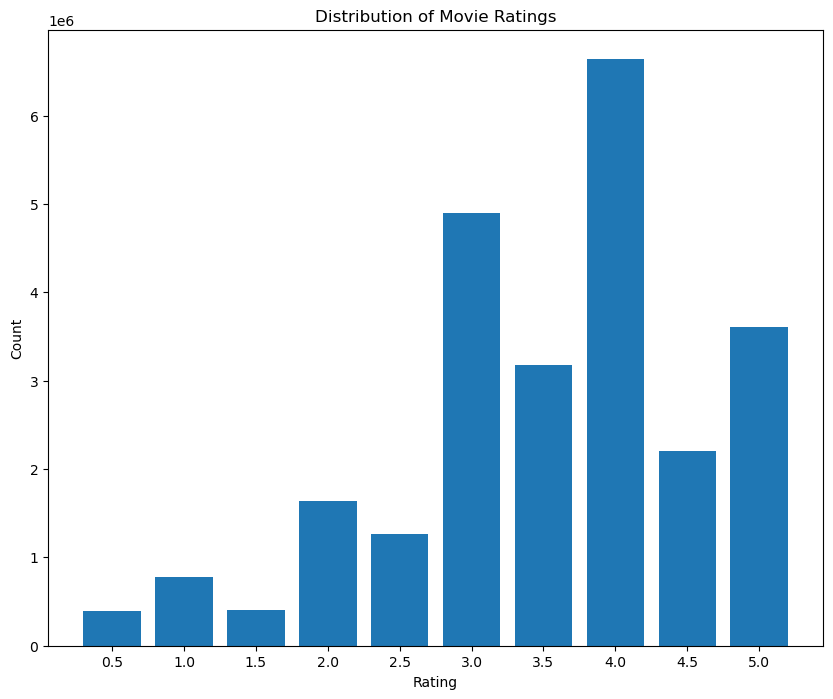

In [11]:
### Plotting the distribution of ratings

import matplotlib.pyplot as plt
ratings_pandas = ratings_distribution.toPandas()

plt.figure(figsize=(10,8))

plt.bar(ratings_pandas['rating'], ratings_pandas['count'])

plt.title('Distribution of Movie Ratings')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [12]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import IntegerType

df_merged_new = df_merged.withColumn('year', regexp_extract(df_merged['title'], r'\((\d{4})\)', 1).cast(IntegerType()))

In [13]:
## Top 10 most rated movies
from pyspark.sql.functions import col

grouped_data = df_merged.groupBy('title').count()

ordered_data = grouped_data.orderBy(col('count').desc())

most_rated = ordered_data.limit(10)

most_rated.show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
| Forrest Gump (1994)|81491|
|Shawshank Redempt...|81482|
| Pulp Fiction (1994)|79672|
|Silence of the La...|74127|
|  Matrix, The (1999)|72674|
|Star Wars: Episod...|68717|
|Jurassic Park (1993)|64144|
|Schindler's List ...|60411|
|   Braveheart (1995)|59184|
|   Fight Club (1999)|58773|
+--------------------+-----+



In [14]:
most_rated.show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
| Forrest Gump (1994)|81491|
|Shawshank Redempt...|81482|
| Pulp Fiction (1994)|79672|
|Silence of the La...|74127|
|  Matrix, The (1999)|72674|
|Star Wars: Episod...|68717|
|Jurassic Park (1993)|64144|
|Schindler's List ...|60411|
|   Braveheart (1995)|59184|
|   Fight Club (1999)|58773|
+--------------------+-----+



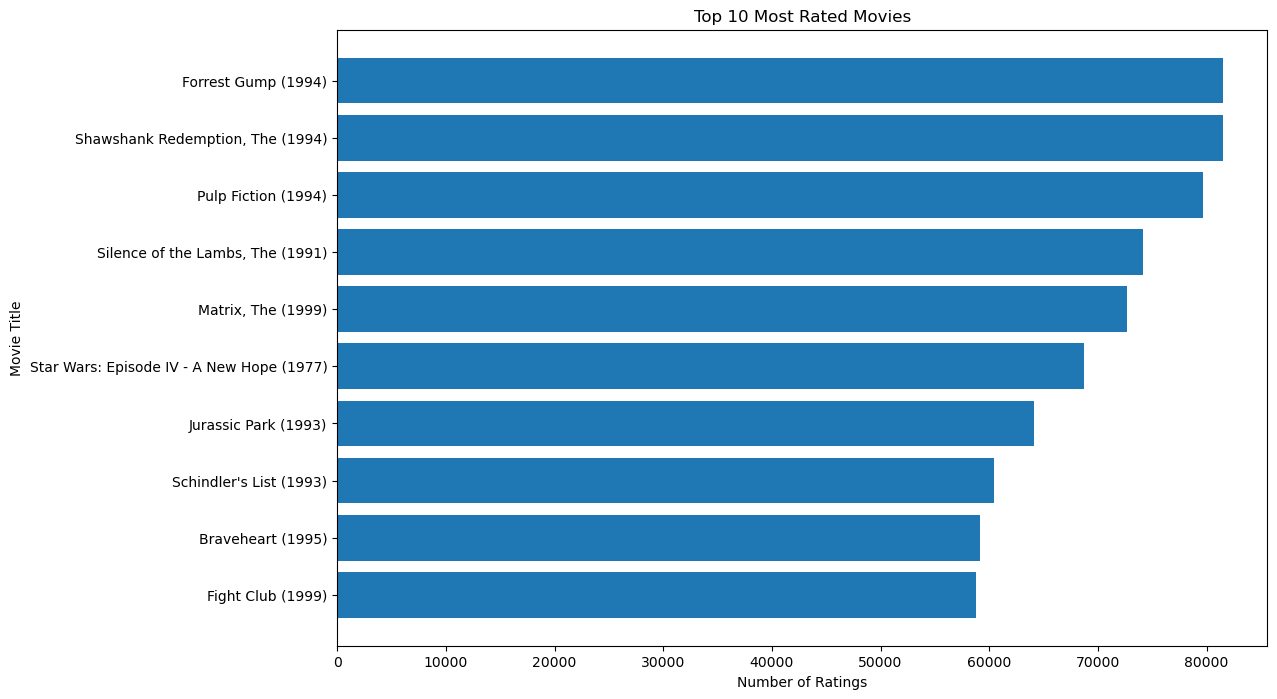

In [15]:
most_rated_pandas = most_rated.toPandas()

plt.figure(figsize=(12,8))
plt.barh(most_rated_pandas['title'], most_rated_pandas['count'])

plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings',)

plt.ylabel('Movie Title')

plt.gca().invert_yaxis()

plt.show()

#### Plotting the average rating of the top 10 most rated movies
 

In [16]:
average_ratings = df_merged.groupBy('title').agg(avg('rating').alias('average_rating'))

In [17]:
average_ratings_top_10 = most_rated.join(average_ratings, on = 'title').select('title','average_rating')

In [18]:
average_ratings_top_10.show()

+--------------------+------------------+
|               title|    average_rating|
+--------------------+------------------+
| Forrest Gump (1994)| 4.048011436845787|
|Shawshank Redempt...| 4.413576004516335|
|   Fight Club (1999)| 4.228310618821568|
|Star Wars: Episod...| 4.120188599618726|
|Schindler's List ...| 4.247579083279535|
|Silence of the La...| 4.151341616415071|
|  Matrix, The (1999)| 4.154099127610975|
| Pulp Fiction (1994)| 4.188912039361382|
|   Braveheart (1995)| 4.002272573668559|
|Jurassic Park (1993)|3.6791749812920926|
+--------------------+------------------+



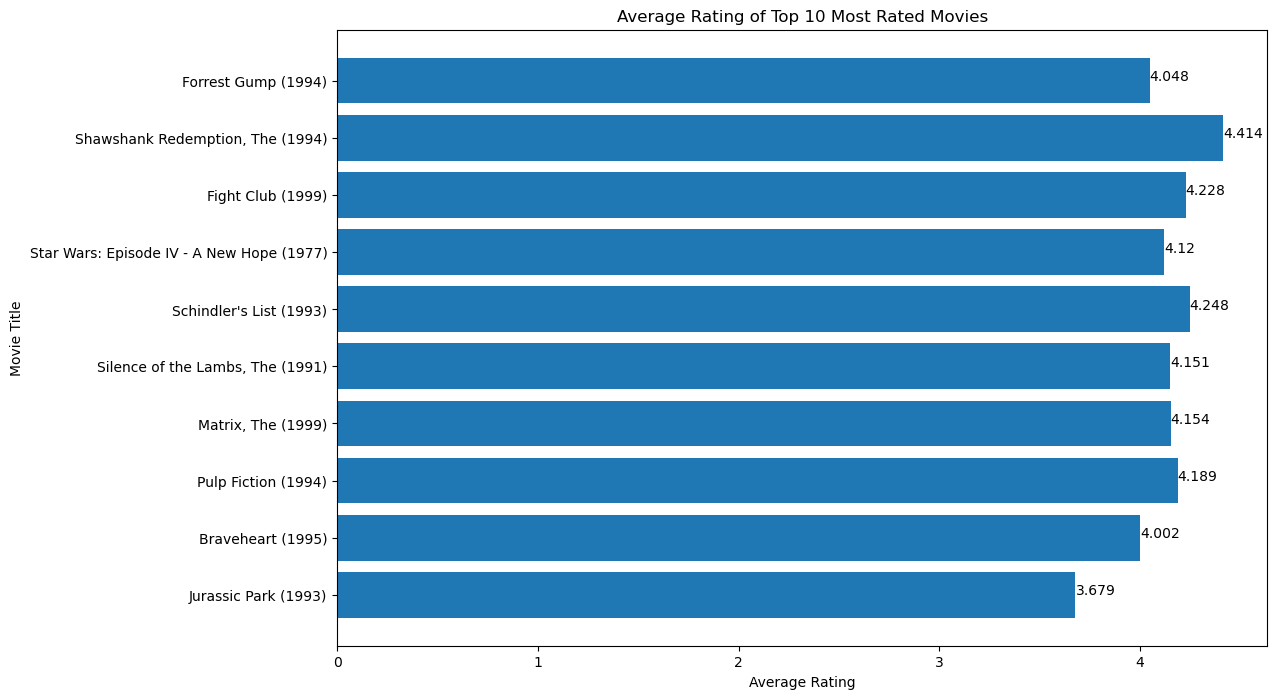

In [26]:
average_ratings_top_10_pandas = average_ratings_top_10.toPandas()
plt.figure(figsize=(12,8), edgecolor="red")

plt.barh(average_ratings_top_10_pandas['title'],average_ratings_top_10_pandas['average_rating'])

plt.title("Average Rating of Top 10 Most Rated Movies")

for i,v in enumerate(average_ratings_top_10_pandas['average_rating']):
    plt.text(v,i,str(round(v,3)))



plt.xlabel("Average Rating")
plt.ylabel("Movie Title")





plt.gca().invert_yaxis()
plt.show()





### Average rating per genre

In [27]:
df_merged = df_merged.withColumn('genres', explode(split(col('genres'),'[|]')))

In [31]:
average_rating_genre = df_merged.groupBy('genres').agg(avg('rating').alias('average_rating')).orderBy('average_rating', ascending = False)

In [32]:
average_rating_genre.show(10)

+-----------+------------------+
|     genres|    average_rating|
+-----------+------------------+
|  Film-Noir|3.9257281769386028|
|        War|3.7914657875591984|
|Documentary|3.7052805249822454|
|      Crime| 3.685043693003225|
|      Drama| 3.677184674800756|
|    Mystery| 3.670169244577933|
|  Animation| 3.614946348438093|
|       IMAX|3.6037121959523324|
|    Western|3.5857553061515595|
|    Musical| 3.554715987107105|
+-----------+------------------+
only showing top 10 rows



### Plotting the average rating per genre

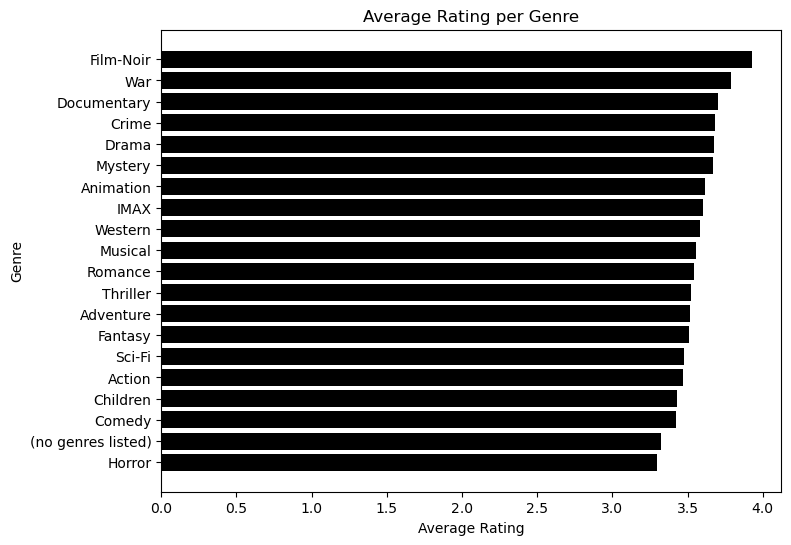

In [34]:
average_rating_genre_pandas = average_rating_genre.toPandas()

plt.figure(figsize=(8,6))
plt.barh(average_rating_genre_pandas['genres'], average_rating_genre_pandas['average_rating'], color = 'black')
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")

plt.gca().invert_yaxis()
plt.show()